# 1D harmonic oscillator physics-informed neural network (PINN)

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

In [91]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [92]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([10, 1]) torch.Size([10, 1])


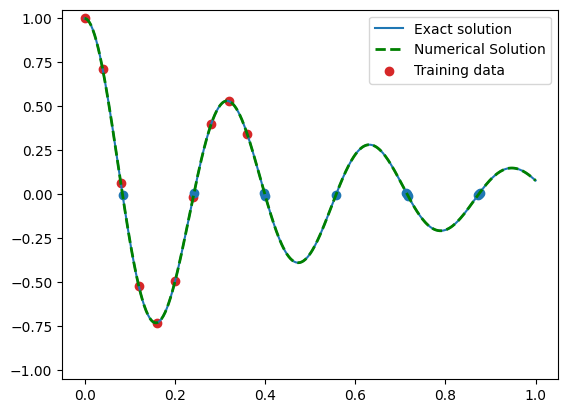

In [90]:
# Parameters and initial conditions

d, w0 = 2, 20
X0 = [1, 0]

# time domain
t = torch.linspace(0, 1, 500).view(-1,1)

# Exact Solution
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    w   = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    x   = torch.exp(-d * t) * 1/(np.cos(phi)) * torch.cos(phi + w*t)
    return x

x_exact = oscillator(d, w0, t).view(-1,1)

# Numerical Solution
def ODE(X, t):
    dXdt = [X[1], -2*d*X[1]-w0**2*X[0]]
    return dXdt

solution = odeint(ODE, X0, t.numpy().flatten())
x        = torch.from_numpy(solution[:,0]).view(-1,1)

solution.dtype = np.double

# Pick a few points from the left hand side to be training data
t_data = t[0:200:20]
x_data = x[0:200:20]
exact_data = x_exact[0:200:20]
print(t_data.shape, x_data.shape)

plt.figure()

zeros = torch.abs(x_exact) < 1e-2

plt.plot(t, x_exact, label="Exact solution")
plt.plot(t, solution[:,0], label="Numerical Solution", color='g', lw=2, alpha=1, linestyle='--')
plt.scatter(t_data, x_data, color="tab:red", label="Training data")
plt.scatter(t[zeros], x_exact[zeros])
plt.ylim(-1.05, 1.05)
plt.legend()
plt.savefig("Superposition.png")
plt.show()

In [70]:
x_exact[zeros]

tensor([ 0.0072, -0.0082])

In [6]:
# Plotting Function

def plot_result(i, t, x, t_data, x_data, xh,tp=None,):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    
    plt.plot(t, x,  color="grey",     linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(t, xh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(t_data, x_data, s=60, color="tab:orange", alpha=0.6, label='Training data')
    if tp is not None:
        plt.scatter(tp, -0*torch.ones_like(tp), s=40, color="tab:green", alpha=0.4, label='Physics loss training locations')
        
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

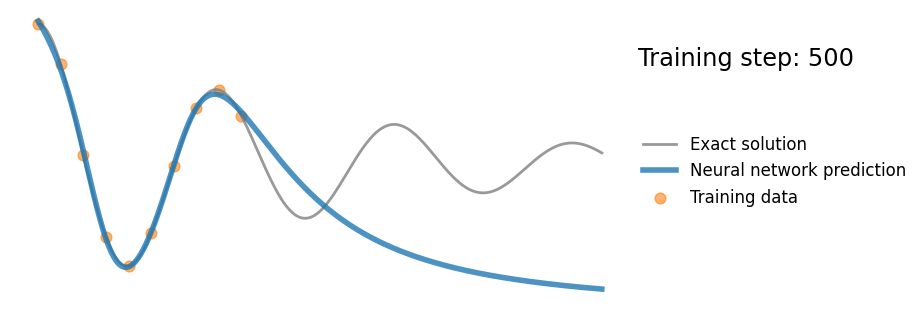

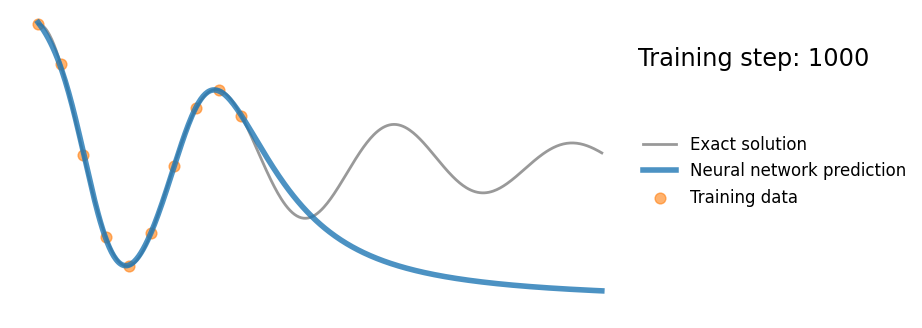

In [7]:

# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []

for i in range(1000):
    optimizer.zero_grad()
    xh = model(t_data.to(torch.float32))
    loss = torch.mean((xh-x_data)**2) # use mean squared error
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        xh = model(t).detach()
        
        plot_result(i, t, x, t_data, x_data, xh)
        
        file = "plots/nn_test_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("gifs/nn_test.gif", files, fps=20, loop=0)

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

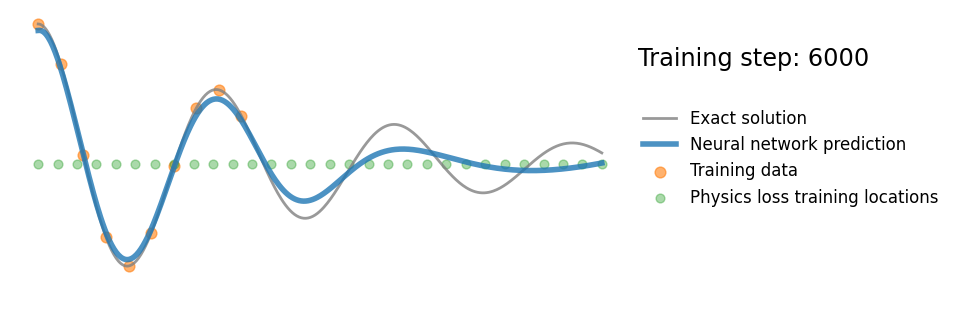

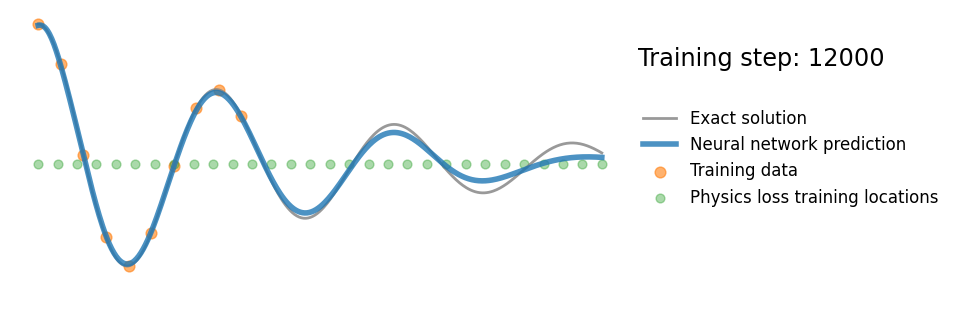

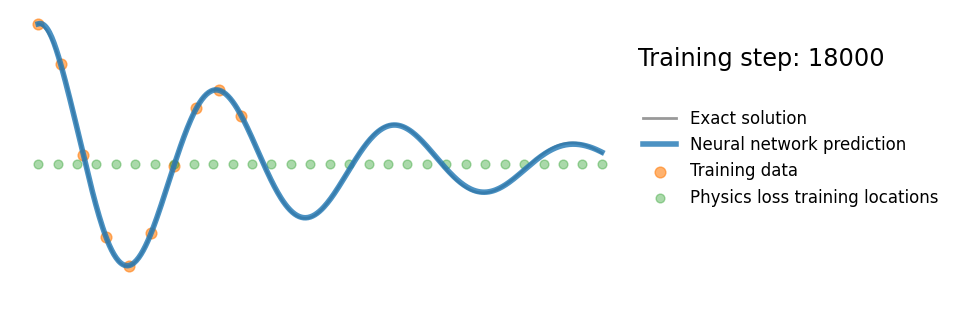

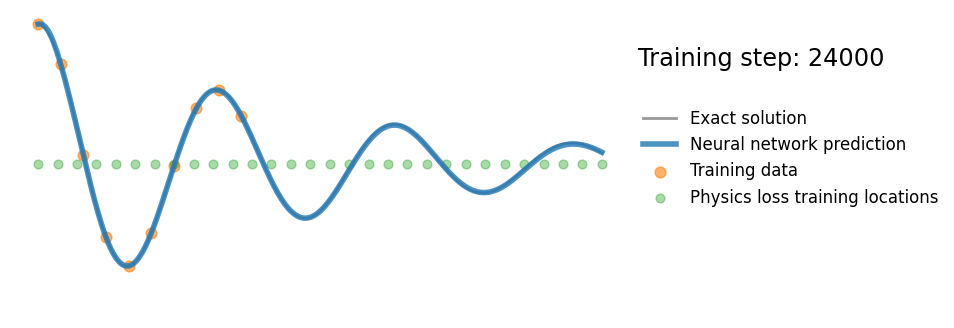

In [14]:
# Define the sample locations for physics loss
t_physics = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(24000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    xh = model(t_data)
    loss1 = torch.mean((xh-x_data)**2)# use mean squared error
    
    # compute the "physics loss"
    xhp = model(t_physics)
    dx  = torch.autograd.grad(xhp, t_physics, torch.ones_like(xhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  t_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = (dx2 + 2*d*dx + w0**2*xhp) # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        xh = model(t).detach()
        tp = t_physics.detach()
        
        plot_result(i, t, x, t_data, x_data, xh, tp)
        
        file = "plots/pinn_test_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("gifs/pinn_test.gif", files, fps=20, loop=0)

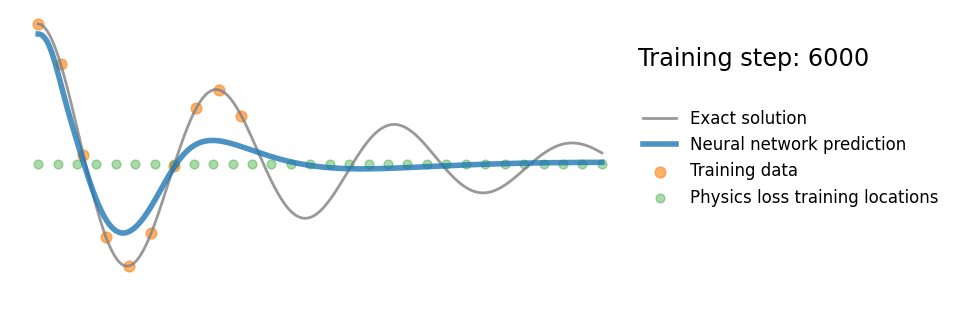

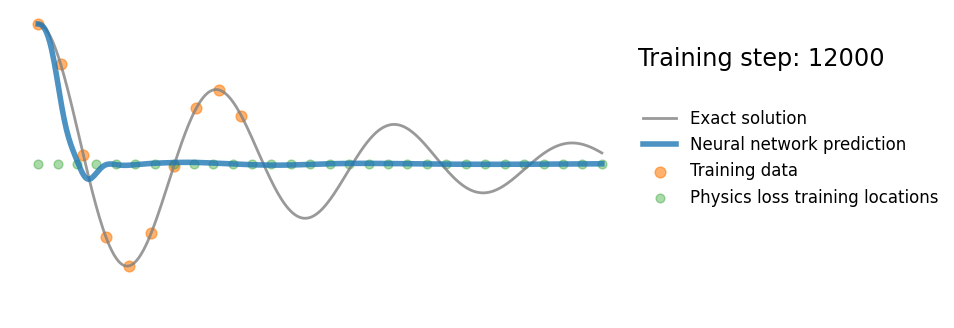

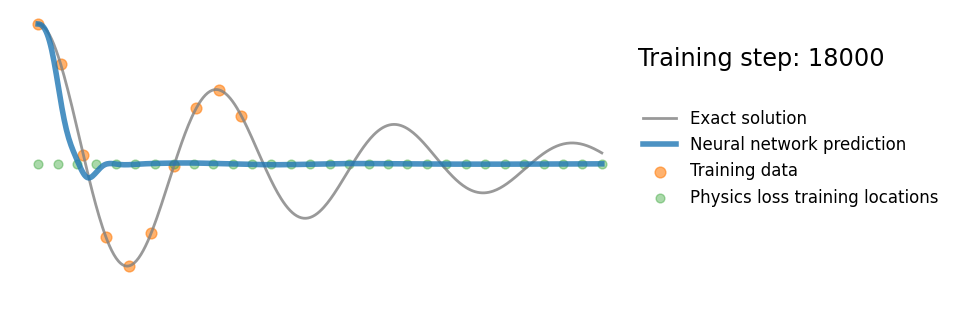

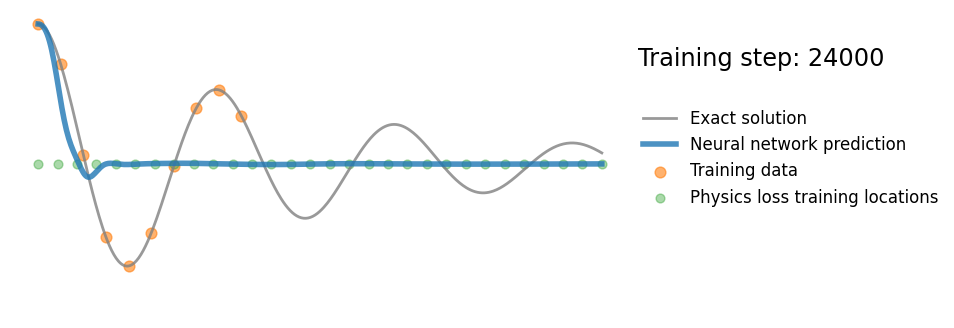

In [96]:
# Define the sample locations for physics loss
t_physics = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)

torch.manual_seed(123)
model2 = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model2.parameters(),lr=1e-4)
files = []
for i in range(24000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    xh = model2(t_data)
    loss1 = torch.mean((xh-exact_data)**2)# use mean squared error
    
    # compute the "physics loss"
    xhp = model2(t_physics)
    dx  = torch.autograd.grad(xhp, t_physics, torch.ones_like(xhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  t_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = (dx2 + 2*d*dx + w0**2*xhp) # computes the residual of the 1D harmonic oscillator differential equation
    
    # backpropagate joint loss
    loss = (1e-4)*torch.mean(physics**2) + (xhp[0] - X0[0])**2 + (dx[0] - X0[1])**2
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        xh = model2(t).detach()
        tp = t_physics.detach()
        
        plot_result(i, t, x, t_data, exact_data, xh, tp)
        
        file = "plots/pinn_test_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("gifs/pinn_test.gif", files, fps=20, loop=0)

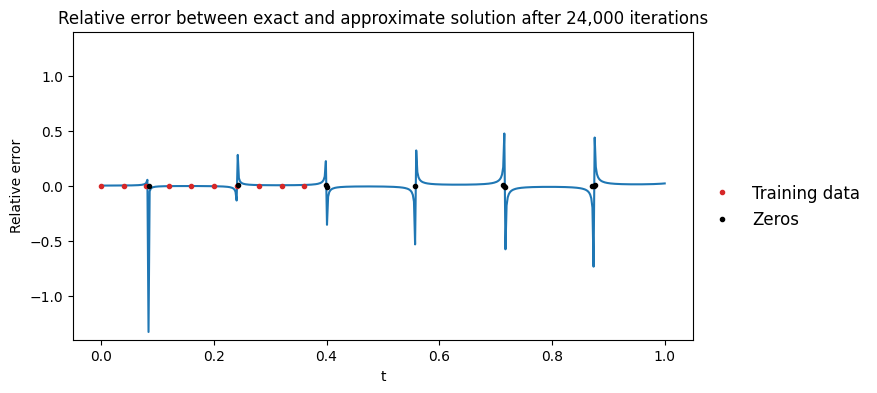

In [88]:
exact_sol = model2(t).detach()
approx_sol = model(t).detach()

dx = (exact_sol - approx_sol)/exact_sol
plt.figure(figsize=(8,4))
plt.plot(t, dx)
plt.plot(t_data, (exact_data-x_data)/exact_data, 'o', color="tab:red", label="Training data", markersize=3)
plt.plot(t[zeros], x_exact[zeros], 'o', color="k", label="Zeros", markersize=3)
plt.ylim(-1.4, 1.4)
plt.title("Relative error between exact and approximate solution after 24,000 iterations")
plt.xlabel("t")
plt.ylabel("Relative error")
l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
plt.setp(l.get_texts(), color="k")
plt.savefig("relative_error.png")
plt.show()


tensor([0.0842, 0.0862, 0.0882, 0.0902, 0.0922, 0.0942, 0.0962, 0.0982, 0.1002,
        0.1022, 0.1042, 0.1062, 0.1082, 0.1102, 0.1122, 0.1142, 0.1162, 0.1182,
        0.1202, 0.1222, 0.1242, 0.1263, 0.1283, 0.1303, 0.1323, 0.1343, 0.1363,
        0.1383, 0.1403, 0.1423, 0.1443, 0.1463, 0.1483, 0.1503, 0.1523, 0.1543,
        0.1563, 0.1583, 0.1603, 0.1623, 0.1643, 0.1663, 0.1683, 0.1703, 0.1723,
        0.1743, 0.1764, 0.1784, 0.1804, 0.1824, 0.1844, 0.1864, 0.1884, 0.1904,
        0.1924, 0.1944, 0.1964, 0.1984, 0.2004, 0.2024, 0.2044, 0.2064, 0.2084,
        0.2104, 0.2124, 0.2144, 0.2164, 0.2184, 0.2204, 0.2224, 0.2244, 0.2265,
        0.2285, 0.2305, 0.2325, 0.2345, 0.2365, 0.2385, 0.2405, 0.4008, 0.4028,
        0.4048, 0.4068, 0.4088, 0.4108, 0.4128, 0.4148, 0.4168, 0.4188, 0.4208,
        0.4228, 0.4248, 0.4269, 0.4289, 0.4309, 0.4329, 0.4349, 0.4369, 0.4389,
        0.4409, 0.4429, 0.4449, 0.4469, 0.4489, 0.4509, 0.4529, 0.4549, 0.4569,
        0.4589, 0.4609, 0.4629, 0.4649, 